<a href="https://colab.research.google.com/github/williamtbarker/ML4Molecules/blob/main/06_Graph_Neural_Networks_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training GNN

We will use the same process discussed earlier. But, for featurization we will use graphs and the model will be a message passing neural network.

The process of training and validating model is below --

1. Clean up dataset
2. Featurize the data
3. Split the dataset
4. Create ``DataLoader`` for the dataset splits
5. Create the ML model, define loss function and optimizer
6. ``for`` loop for epochs
    1. ``for`` loop for training batches
        1. Do a forward pass
        2. Compute the loss
        3. Do backpropogation
    2. ``for`` loop for validation batches
        1. Do a forward pass
        2. Compute the loss
    

### Installing the packages

In [1]:
# install dgl, rdkit and fast-ml
! pip install dgl
! pip install dgllife
! pip install rdkit
! pip install fast_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 844.4 kB/s eta 0:00:00


### Dataset operations

We will fetch the QM9 dataset and use HOMO-LUMO gap as the target for prediction.

In [2]:
# import pandas library
import pandas as pd

# load the dataframe as CSV from URL.
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")

# create the dataset with smiles and gap
# we will use a 5% of the dataset to save time
dataset = df[["smiles","gap"]].sample(frac=0.05)

As we will use GNN, we need to convert the SMILES to graphs with atom and bond features. The dgl library has streamlined this process.

We will use the ``CanonicalAtomFeaturizer`` for atoms features and ``CanonicalBondFeaturizer`` for bonds. More details on the features can be found [here]()

In [3]:
# import from rdkit and dgl-lifesci
from rdkit import Chem
from dgllife.utils import CanonicalAtomFeaturizer, CanonicalBondFeaturizer, \
mol_to_bigraph

# create the atom and bond featurizer object
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field="hv")
bond_featurizer = CanonicalBondFeaturizer(bond_data_field="he")

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Before applying the featurizers to entire dataset, let us look at generating a graph for ethane and applying the features

In [4]:
smiles = "CC"

# mol_to_graph requires the RDKit molecule and featurizers
mol = Chem.MolFromSmiles(smiles)
graph = mol_to_bigraph(mol, node_featurizer=atom_featurizer,
                     edge_featurizer=bond_featurizer)

# display the graph object
graph

Graph(num_nodes=2, num_edges=2,
      ndata_schemes={'hv': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'he': Scheme(shape=(12,), dtype=torch.float32)})

Atom features:
* One hot encoding of the atom type
* One hot encoding of the atom degree
* One hot encoding of the number of implicit Hs on the atom
* ...

More details in [documentation](https://lifesci.dgl.ai/api/utils.mols.html#featurization-for-molecules.)

We will create the graphs for all entries in the dataset.


In [5]:
# helper function to convert smiles to graph
def smiles2graph(smiles):
  mol = Chem.MolFromSmiles(smiles)
  graph = mol_to_bigraph(mol, node_featurizer=atom_featurizer,
                     edge_featurizer=bond_featurizer)
  return graph

In [6]:
dataset["graph"] = dataset["smiles"].apply(smiles2graph)

Here, we use random splitting with Fast-ML. Other splitters could also be used.

In [7]:
# import the function to split into train-valid-test
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, \
X_test, y_test = train_valid_test_split(dataset[["graph","gap"]],
                                        target = "gap",
                                        train_size=0.8,
                                        valid_size=0.1,
                                        test_size=0.1)

Looking a the dataset

In [8]:
X_test.head()

,graph
50303,"Graph(num_nodes=9, num_edges=20,\n ndata_..."
87462,"Graph(num_nodes=9, num_edges=22,\n ndata_..."
64871,"Graph(num_nodes=9, num_edges=18,\n ndata_..."
107320,"Graph(num_nodes=9, num_edges=20,\n ndata_..."
30188,"Graph(num_nodes=9, num_edges=20,\n ndata_..."


### Dataloader

The ``DataLoader`` helps in creating batches, shuffling data and feeding the data into to model during training. The dataloader requires the dataset in the form (X,y) where X is the graph and y is the target.

The dataloader code below does this transformation. The ``collate_data`` function is need for batching the (X,y) entries before feeding the batches into the model.

In [9]:
import dgl

def collate_data(data):
  # our data is in the form of list of (X,y)
  # the map function thus maps accordingly
  graphs, y = map(list, zip(*data))

  # for creating a batch of graph, we use the batch function
  batch_graph = dgl.batch(graphs)

  # we need to stack the ys for different entries in the batch
  y = torch.stack(y, dim=0)

  return batch_graph, y

In [10]:
# import dataloader
import torch
from torch.utils.data import DataLoader

# create the dataloader for train dataset
# dataset should be of form (X,y) according to the collate function
# the ys should also be converted to tensors
train_dataloader = DataLoader(
    dataset=list(zip(X_train["graph"].values.tolist(),
                     torch.tensor(y_train.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

We can look at the first entry of the train_dataloader with -

In [11]:
train_dataloader.dataset[0]

(Graph(num_nodes=9, num_edges=18,
       ndata_schemes={'hv': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'he': Scheme(shape=(12,), dtype=torch.float32)}),
 tensor(0.2149))

Repeat the same for the valid_dataset and test_dataset

In [12]:
valid_dataloader = DataLoader(
    dataset=list(zip(X_valid["graph"].values.tolist(),
                     torch.tensor(y_valid.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

test_dataloader = DataLoader(
    dataset=list(zip(X_test["graph"].values.tolist(),
                     torch.tensor(y_test.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

### Model, loss and optimizer

Here, we will use a the MPNN model from dgl-lifesci package. List of available models can be found [here](https://lifesci.dgl.ai/api/model.zoo.html)

In [13]:
# import MLP model from dgl-lifesci
from dgllife.model.model_zoo.mpnn_predictor import MPNNPredictor

# the atom feature length is 74 and bond is 12
model = MPNNPredictor(node_in_feats = 74,
                      edge_in_feats = 12,
                      node_out_feats = 64,
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3)
model

MPNNPredictor(
  (gnn): MPNNGNN(
    (project_node_feats): Sequential(
      (0): Linear(in_features=74, out_features=64, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=12, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=4096, bias=True)
      )
    )
    (gru): GRU(64, 64)
  )
  (readout): Set2Set(
    n_iters=6
    (lstm): LSTM(128, 64, num_layers=3)
  )
  (predict): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

The ``MPNNPredictor`` contains a ``gnn``, ``readout`` and ``predict`` layers.

In [14]:
# loss function for regresssion is usually mean squared error
import torch

loss_func = torch.nn.MSELoss(reduce=None)

We will use the Adam optimizer for training.

In [15]:
# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Model training and validation

We follow the steps in the overview

In [16]:
epochs = 5

# loop over epochs
for epoch in range(epochs):
  print("\nStarting Epoch", epoch+1)

  # set the model to train so the parameters can be updated
  model.train()
  # loop over training batches

  train_loss = []
  for batch in train_dataloader:

    # Do a forward pass
    batch_graph, target = batch

    # look at the forward function for input
    # this model needs graph, node_feats and edge_feats
    node_feats = batch_graph.ndata["hv"]
    edge_feats = batch_graph.edata["he"]
    predictions = model(batch_graph, node_feats, edge_feats)

    # Compute loss
    loss = (loss_func(predictions, target)).mean()
    optimizer.zero_grad()

    # Do back propogation and update gradient
    loss.backward()
    optimizer.step()

    # save loss to compute average loss
    train_loss.append(loss)

  print("Training loss", torch.tensor(train_loss).mean().item())



  # set the model to eval so the parameters are not updated
  model.eval()
  valid_loss = []

  # loop over validation batches
  with torch.no_grad():
    for batch in valid_dataloader:

      # Do a forward pass
      batch_graph, target = batch
      node_feats = batch_graph.ndata["hv"]
      edge_feats = batch_graph.edata["he"]
      predictions = model(batch_graph, node_feats, edge_feats)

      # Compute loss and gradient
      loss = (loss_func(predictions, target)).mean()

      # save loss to compute average loss
      valid_loss.append(loss)

  print("Validation loss ", torch.tensor(valid_loss).mean().item())



Starting Epoch 1
Training loss 0.004100590478628874
Validation loss  0.0023228006903082132

Starting Epoch 2
Training loss 0.00227018422447145
Validation loss  0.0022429139353334904

Starting Epoch 3
Training loss 0.002283029956743121
Validation loss  0.002242504386231303

Starting Epoch 4
Training loss 0.00228515756316483
Validation loss  0.002244254807010293

Starting Epoch 5
Training loss 0.0022777284029871225
Validation loss  0.0022511593997478485


### Testing the performance

We can get a random sample from the test dataset and look at the predicted and true value

In [17]:
# getting a sample with idx
idx = 100
graph_sample = X_test["graph"].iloc[idx]
y_sample = y_test.iloc[idx]

print("True value is ",y_sample)

True value is  0.2883


In [18]:
# get the prediction
model.eval()
node_feats = graph_sample.ndata["hv"]
edge_feats = graph_sample.edata["he"]
model(graph_sample, node_feats, edge_feats)

tensor([[0.2539]], grad_fn=<AddmmBackward0>)

Let us get prediction over the entire test dataset

In [19]:
predicted_values = []
true_values = y_test.to_list()

model.eval()
for graph_sample in X_test["graph"].tolist():
  node_feats = graph_sample.ndata["hv"]
  edge_feats = graph_sample.edata["he"]
  prediction = model(graph_sample, node_feats, edge_feats)
  predicted_values.append(prediction.item())

We can create a scatter plot to look at the correlation

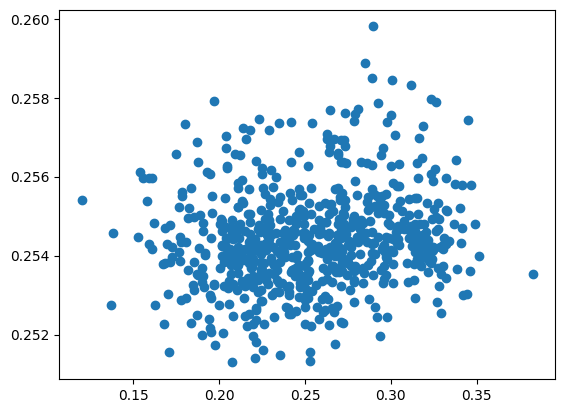

In [20]:
import matplotlib.pyplot as plt

plt.scatter(true_values, predicted_values)

As we noted before, the model predictions are not good; predicts nearly constant value. We can also arrive at the conclusion from the R<sup>2</sup> score

In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

print("R2 score ", r2_score(true_values,predicted_values))
print("MAE ", mean_absolute_error(true_values,predicted_values))

R2 score  0.0077337846176001035
MAE  0.037847806370009236


The implementation of the MPNN model on QM9 is reported in [this](https://arxiv.org/abs/1704.01212) article.